# Task 1: Part I


In [1]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
# a) Initialize 5 qubits
qubits = [cirq.LineQubit(i) for i in range(5)]

# b) Hadamard on all qubits 
circuit = cirq.Circuit()  # Create a circuit
circuit.append(cirq.H(q) for q in qubits) 

# c) CNOT operations
circuit.append([
    cirq.CNOT(qubits[0], qubits[1]),
    cirq.CNOT(qubits[1], qubits[2]),
    cirq.CNOT(qubits[2], qubits[3]),
    cirq.CNOT(qubits[3], qubits[4])
])

# d) SWAP 
circuit.append(cirq.SWAP(qubits[0], qubits[4]))

# e) Rotate X
circuit.append(cirq.Rx(rads=np.pi/2)(qubits[2]))  # Pick any qubit

# f) Plot the circuit
print(circuit)

0: ───H───@──────────────────────×───
          │                      │
1: ───H───X───@──────────────────┼───
              │                  │
2: ───H───────X───@───Rx(0.5π)───┼───
                  │              │
3: ───H───────────X───@──────────┼───
                      │          │
4: ───H───────────────X──────────×───


# Task 1: Part II


In [2]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
# Create qubits
q1, q2, q3, q4 = cirq.LineQubit.range(4)

# Create the circuit
circuit = cirq.Circuit()

# Apply Hadamard to the first qubit
circuit.append(cirq.H(q1))

# Rotate the second qubit by pi/3 around X
circuit.append(cirq.Rx(rads=np.pi/3)(q2))

# Apply Hadamard to the third and fourth qubit
circuit.append(cirq.H(q3))
circuit.append(cirq.H(q4))

# Perform a Swap Test (this requires some explanation - see below)
circuit.append(cirq.CNOT(q1, q3))
circuit.append(cirq.CNOT(q2, q4))
circuit.append(cirq.H(q3))
circuit.append(cirq.measure(q3)) 

# Print the circuit
print(circuit)


                   ┌──┐
0: ───H─────────────@─────────────
                    │
1: ───Rx(0.333π)────┼@────────────
                    ││
2: ───H─────────────X┼────H───M───
                     │
3: ───H──────────────X────────────
                   └──┘


# -------------------------End of Task I Part 1 and Part 2 ---------------------------------


# Task III

# Answer to this part is written in TaskIII.pdf file


# Task II 

In [166]:
import numpy as np
import torch
from torch_geometric.data import Data

# Load dataset
dataset = np.load('QG_jets.npz')
X = dataset['X']  # Shape: (100000, M, 4)
y = dataset['y']  # Shape: (100000,)
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)



Shape of X: (100000, 139, 4)
Shape of y: (100000,)


In [4]:
'''def create_graphs(X, y):
    graphs = []
    for i in range(len(X)):
        # Simplified graph construction; in practice, you'd use k-NN or other criteria
        edge_index = torch.tensor([[0, 1], [1, 2], [2, 3], [3, 4], [0, 4]], dtype=torch.long)  # Example edge index
        x = torch.tensor(X[i], dtype=torch.float)  # Node features
        label = torch.tensor([y[i]], dtype=torch.float)  # Graph label
        
        graph = Data(x=x, edge_index=edge_index.t().contiguous(), y=label)
        graphs.append(graph)
    return graphs

graphs = create_graphs(X, y)'''


"def create_graphs(X, y):\n    graphs = []\n    for i in range(len(X)):\n        # Simplified graph construction; in practice, you'd use k-NN or other criteria\n        edge_index = torch.tensor([[0, 1], [1, 2], [2, 3], [3, 4], [0, 4]], dtype=torch.long)  # Example edge index\n        x = torch.tensor(X[i], dtype=torch.float)  # Node features\n        label = torch.tensor([y[i]], dtype=torch.float)  # Graph label\n        \n        graph = Data(x=x, edge_index=edge_index.t().contiguous(), y=label)\n        graphs.append(graph)\n    return graphs\n\ngraphs = create_graphs(X, y)"

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.model_selection import train_test_split

# Load dataset
dataset = np.load('QG_jets.npz')
X = dataset['X']  # Shape: (100000, M, 4)
y = dataset['y']  # Shape: (100000,)

# Assuming fully connected graphs for simplicity
M = X.shape[1]  # Number of nodes
edges = [[i, j] for i in range(M) for j in range(M) if i != j]
edges = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Convert numpy arrays to PyTorch tensors and prepare PyG Data objects
data_list = []
for i in range(X.shape[0]):
    node_features = torch.tensor(X[i], dtype=torch.float)
    label = torch.tensor([y[i]], dtype=torch.long)
    data = Data(x=node_features, edge_index=edges, y=label)
    data_list.append(data)

# Split dataset
train_data, test_data = train_test_split(data_list, test_size=0.1, random_state=42)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Define the GNN model
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index))

        # Global mean pooling
        x = global_mean_pool(x, batch)

        # Final classifier
        x = self.fc(x)

        return F.log_softmax(x, dim=1)

# Instantiate the model
input_dim = X.shape[2]  # Number of node features
hidden_dim = 16
output_dim = len(np.unique(y))  # Assuming y contains class labels as integers

model = GNN(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss()

# Training function
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Testing function
def test(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            out = model(data)
            _, predicted = torch.max(out, dim=1)
            correct += (predicted == data.y.view(-1)).sum().item()
            total += data.y.size(0)
    return correct / total

# Training and testing loops
num_epochs = 30
for epoch in range(num_epochs):
    loss = train()
    test_acc = test(test_loader)
    print(f'Epoch: {epoch+1}, Loss: {loss:.4f}, Test Acc: {test_acc:.4f}')

C:\Users\91825\AppData\Local\Temp\ipykernel_7016\303723847.py:22: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor([y[i]], dtype=torch.long)
C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 1, Loss: 0.6159, Test Acc: 0.6806
Epoch: 2, Loss: 0.6030, Test Acc: 0.6768
Epoch: 3, Loss: 0.6014, Test Acc: 0.6756
Epoch: 4, Loss: 0.6005, Test Acc: 0.6762
Epoch: 5, Loss: 0.6000, Test Acc: 0.6844
Epoch: 6, Loss: 0.5993, Test Acc: 0.6801
Epoch: 7, Loss: 0.5996, Test Acc: 0.6831
Epoch: 8, Loss: 0.5991, Test Acc: 0.6830
Epoch: 9, Loss: 0.5990, Test Acc: 0.6819
Epoch: 10, Loss: 0.5993, Test Acc: 0.6900
Epoch: 11, Loss: 0.5988, Test Acc: 0.6871
Epoch: 12, Loss: 0.5994, Test Acc: 0.6873
Epoch: 13, Loss: 0.6014, Test Acc: 0.6820
Epoch: 14, Loss: 0.6005, Test Acc: 0.6855
Epoch: 15, Loss: 0.5999, Test Acc: 0.6846
Epoch: 16, Loss: 0.5993, Test Acc: 0.6859
Epoch: 17, Loss: 0.5997, Test Acc: 0.6887
Epoch: 18, Loss: 0.5992, Test Acc: 0.6845


# ------------------------End of Task II-----------------------------#

# Task VIII: Vision transformer/Quantum Vision Transformer

In [8]:
# Check CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [9]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torch.nn.functional as F

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=1, patch_size=28, emb_size=768, img_size=28):
        super().__init__()
        self.patch_size = patch_size
        self.projection = nn.Sequential(
            # Using the entire image as a single patch
            nn.Flatten(),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )
    
    def forward(self, x):
        x = self.projection(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, emb_size=768, heads=8, dropout=0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim=emb_size, num_heads=heads)
        self.norm1 = nn.LayerNorm(emb_size)
        self.norm2 = nn.LayerNorm(emb_size)
        self.ffn = nn.Sequential(
            nn.Linear(emb_size, emb_size * 4),
            nn.GELU(),
            nn.Linear(emb_size * 4, emb_size)
        )
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # Self-attention
        attn, _ = self.attention(x, x, x)
        x = self.norm1(x + self.dropout(attn))
        # Feed-forward
        ffn = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, patch_size=28, emb_size=768, n_classes=10, img_size=28, channels=1):
        super().__init__()
        self.patch_embedding = PatchEmbedding(in_channels=channels, patch_size=patch_size, emb_size=emb_size, img_size=img_size)
        self.transformer_block = TransformerBlock(emb_size=emb_size)
        self.classifier = nn.Linear(emb_size, n_classes)
    
    def forward(self, x):
        x = self.patch_embedding(x)
        x = x.unsqueeze(0)  # Dummy batch dimension for self-attention
        x = self.transformer_block(x)
        x = x.squeeze(0)  # Remove dummy batch dimension
        logits = self.classifier(x)
        return logits

# Model instantiation
model = VisionTransformer()


In [10]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Epoch 0, Loss: 0.3135006697828582
Epoch 1, Loss: 0.17958425032471353
Epoch 2, Loss: 0.14392539788522066
Epoch 3, Loss: 0.12281021503294741
Epoch 4, Loss: 0.10942653459268434
Epoch 5, Loss: 0.09814026987632868
Epoch 6, Loss: 0.08916634589241051
Epoch 7, Loss: 0.08347510157521866
Epoch 8, Loss: 0.07800106217475064
Epoch 9, Loss: 0.07209392435608436


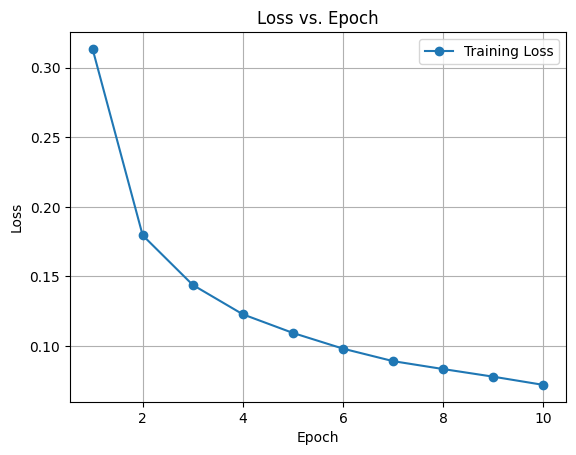

In [12]:
import matplotlib.pyplot as plt

# Initialize a list to store loss values
loss_values = []

for epoch in range(10):  # Example epoch count
    epoch_losses = []
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    # Calculate average loss for the epoch
    epoch_loss = sum(epoch_losses) / len(epoch_losses)
    loss_values.append(epoch_loss)
    print(f"Epoch {epoch}, Loss: {epoch_loss}")

# Plotting
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, '-o', label='Training Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Proposal for Qantum Vision Transformer
# 1. Develop quantum data loaders for efficiently encoding images into quantum states
# 2. Introduce quantum orthogonal layers to utilize unique quantum properties such as superposition and entanglement in processing image data.
# 3.  Implement a basic quantum transformer model that processes each image patch independently with guaranteed orthogonality in the weight matrices.
# 4. Create a more complex model that closely mimics classical transformers, utilizing quantum circuits for both feature extraction and patch interaction.


# ------------------------End of Task VIII-------------------------#

# Reference: Kerenidis, Iordanis, et al. "Quantum Vision Transformers." Quantum 8 (2024): 1265.

# Task IV: Quantum Generative Adversarial Network (QGAN)


In [64]:
import numpy as np
data = np.load('QIS_EXAM_200Events.npz', allow_pickle=True)
print(data.files)
field1 = data['training_input'] 
field2 = data['test_input']  
print(field1)
print(field2)
data.close()


['training_input', 'test_input']
{'0': array([[-0.43079088,  0.86834819, -0.92614721, -0.92662029, -0.56900862],
       [ 0.33924198,  0.56155499,  0.93097459, -0.91631726, -0.54463516],
       [-0.42888879,  0.87064961, -0.92782179, -0.77533991, -0.58329176],
       [-0.43262871,  0.86128919, -0.92240878, -0.88048862, -0.49963115],
       [-0.99925345, -0.99949586,  0.07753685, -0.84218034, -0.5149399 ],
       [-0.99631106, -0.99775978,  0.0756427 , -0.54117216, -0.66299335],
       [-0.42645921,  0.87141204, -0.92908723, -0.52650143, -0.62187526],
       [ 0.34317906,  0.57125045,  0.92638556, -0.85113425, -0.40170562],
       [-0.99904849, -0.99933931,  0.07737929, -0.81161066, -0.53550246],
       [ 0.3371327 ,  0.55874622,  0.92996976, -0.9117092 , -0.50996097],
       [ 0.89649306, -0.95523176, -0.66298651, -0.71276678, -0.62698893],
       [ 0.34293232,  0.56408047,  0.93448436, -0.88789589, -0.56154273],
       [-0.43055876,  0.86615566, -0.92532229, -0.82531102, -0.61433506],

In [53]:
# Extract the encapsulated object from the 0-d arrays
training_input_obj = data['training_input'].item()
test_input_obj = data['test_input'].item()

# Initialize containers for the combined data and labels
combined_training_data = []
combined_training_labels = []
combined_test_data = []
combined_test_labels = []

# Now, you can iterate over the dictionary objects
for key in training_input_obj:
    combined_training_data.extend(training_input_obj[key])
    combined_training_labels.extend([int(key)] * len(training_input_obj[key]))

for key in test_input_obj:
    combined_test_data.extend(test_input_obj[key])
    combined_test_labels.extend([int(key)] * len(test_input_obj[key]))

# Convert lists to numpy arrays for further processing
combined_training_data = np.array(combined_training_data)
combined_training_labels = np.array(combined_training_labels)
combined_test_data = np.array(combined_test_data)
combined_test_labels = np.array(combined_test_labels)


In [54]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Create a machine learning pipeline
pipeline = make_pipeline(StandardScaler(), SVC(gamma='auto'))

# Train the model with the training data
pipeline.fit(combined_training_data, combined_training_labels)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [55]:
from sklearn.metrics import accuracy_score

# Predict the labels for the test data
test_predictions = pipeline.predict(combined_test_data)

# Calculate the accuracy
accuracy = accuracy_score(combined_test_labels, test_predictions)

print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 71.00%


In [56]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate a classification report
report = classification_report(combined_test_labels, test_predictions, target_names=['Class 0', 'Class 1'])
print(report)

# Generate and display the confusion matrix
cm = confusion_matrix(combined_test_labels, test_predictions)
print("Confusion Matrix:")
print(cm)


              precision    recall  f1-score   support

     Class 0       0.69      0.76      0.72        50
     Class 1       0.73      0.66      0.69        50

    accuracy                           0.71       100
   macro avg       0.71      0.71      0.71       100
weighted avg       0.71      0.71      0.71       100

Confusion Matrix:
[[38 12]
 [17 33]]


In [57]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model with the training data
random_forest.fit(combined_training_data, combined_training_labels)


RandomForestClassifier(random_state=42)

In [58]:
# Predict the labels for the test data
rf_test_predictions = random_forest.predict(combined_test_data)

# Calculate the accuracy
rf_accuracy = accuracy_score(combined_test_labels, rf_test_predictions)
print(f"Random Forest Test Accuracy: {rf_accuracy * 100:.2f}%")

# Generate a classification report
rf_report = classification_report(combined_test_labels, rf_test_predictions, target_names=['Class 0', 'Class 1'])
print("Random Forest Classification Report:")
print(rf_report)

# Generate and display the confusion matrix
rf_cm = confusion_matrix(combined_test_labels, rf_test_predictions)
print("Random Forest Confusion Matrix:")
print(rf_cm)


Random Forest Test Accuracy: 67.00%
Random Forest Classification Report:
              precision    recall  f1-score   support

     Class 0       0.67      0.66      0.67        50
     Class 1       0.67      0.68      0.67        50

    accuracy                           0.67       100
   macro avg       0.67      0.67      0.67       100
weighted avg       0.67      0.67      0.67       100

Random Forest Confusion Matrix:
[[33 17]
 [16 34]]


In [59]:
from sklearn.preprocessing import StandardScaler

# Scale the combined training and test data
scaler = StandardScaler()
training_data_scaled = scaler.fit_transform(combined_training_data)
test_data_scaled = scaler.transform(combined_test_data)


In [60]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the neural network architecture
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(training_data_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summarize the model architecture
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                384       
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4609 (18.00 KB)
Trainable params: 4609 (18.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [61]:
# Train the model
history = model.fit(training_data_scaled, combined_training_labels,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2,  # Use 20% of the training data as validation data
                    verbose=1)


Epoch 1/20
3/3 [==============================] - 1s 54ms/step - loss: 0.6991 - accuracy: 0.3875 - val_loss: 0.7013 - val_accuracy: 0.5500
Epoch 2/20
3/3 [==============================] - 0s 17ms/step - loss: 0.6671 - accuracy: 0.4625 - val_loss: 0.7135 - val_accuracy: 0.4000
Epoch 3/20
3/3 [==============================] - 0s 13ms/step - loss: 0.6362 - accuracy: 0.6625 - val_loss: 0.7157 - val_accuracy: 0.4500
Epoch 4/20
3/3 [==============================] - 0s 16ms/step - loss: 0.6112 - accuracy: 0.7125 - val_loss: 0.7160 - val_accuracy: 0.4500
Epoch 5/20
3/3 [==============================] - 0s 14ms/step - loss: 0.5879 - accuracy: 0.7625 - val_loss: 0.7164 - val_accuracy: 0.5000
Epoch 6/20
3/3 [==============================] - 0s 13ms/step - loss: 0.5672 - accuracy: 0.8000 - val_loss: 0.7187 - val_accuracy: 0.4000
Epoch 7/20
3/3 [==============================] - 0s 14ms/step - loss: 0.5492 - accuracy: 0.8000 - val_loss: 0.7247 - val_accuracy: 0.4000
Epoch 8/20
3/3 [===========

In [62]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_data_scaled, combined_test_labels, verbose=2)
print(f'\nTest Accuracy: {test_acc * 100:.2f}%')


4/4 - 0s - loss: 0.7316 - accuracy: 0.6900 - 19ms/epoch - 5ms/step

Test Accuracy: 69.00%


In [165]:
'''import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()
'''

"import matplotlib.pyplot as plt\n\n# Plot training & validation accuracy values\nplt.plot(history.history['accuracy'], label='Train')\nplt.plot(history.history['val_accuracy'], label='Validation')\nplt.title('Model accuracy')\nplt.ylabel('Accuracy')\nplt.xlabel('Epoch')\nplt.legend(loc='upper left')\nplt.show()\n\n# Plot training & validation loss values\nplt.plot(history.history['loss'], label='Train')\nplt.plot(history.history['val_loss'], label='Validation')\nplt.title('Model loss')\nplt.ylabel('Loss')\nplt.xlabel('Epoch')\nplt.legend(loc='upper left')\nplt.show()\n"

# --------------------------------End of Task IV------------------------------------

# Task V  Quantum Graph Neural Network (QGNN) 

In [136]:
# Ref: https://pennylane.ai/qml/demos/tutorial_qgrnn/
import pennylane as qml
from matplotlib import pyplot as plt
from pennylane import numpy as np
import scipy
import networkx as nx
import copy

In [147]:
qubit_number = 4
qubits = range(qubit_number)

Edges: [(0, 1), (0, 3), (1, 2), (2, 3)]


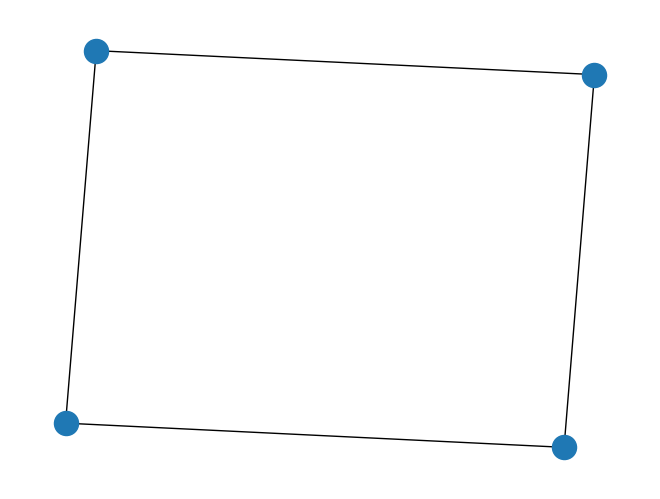

In [148]:
ising_graph = nx.cycle_graph(qubit_number)

print(f"Edges: {ising_graph.edges}")
nx.draw(ising_graph)

In [149]:
target_weights = [0.56, 1.24, 1.67, -0.79]
target_bias = [-1.44, -1.43, 1.18, -0.93]

In [150]:
def create_hamiltonian_matrix(n_qubits, graph, weights, bias):

    full_matrix = np.zeros((2 ** n_qubits, 2 ** n_qubits))

    # Creates the interaction component of the Hamiltonian
    for i, edge in enumerate(graph.edges):
        interaction_term = 1
        for qubit in range(0, n_qubits):
            if qubit in edge:
                interaction_term = np.kron(interaction_term, qml.matrix(qml.PauliZ(0)))
            else:
                interaction_term = np.kron(interaction_term, np.identity(2))
        full_matrix += weights[i] * interaction_term

    # Creates the bias components of the matrix
    for i in range(0, n_qubits):
        z_term = x_term = 1
        for j in range(0, n_qubits):
            if j == i:
                z_term = np.kron(z_term, qml.matrix(qml.PauliZ(0)))
                x_term = np.kron(x_term, qml.matrix(qml.PauliX(0)))
            else:
                z_term = np.kron(z_term, np.identity(2))
                x_term = np.kron(x_term, np.identity(2))
        full_matrix += bias[i] * z_term + x_term

    return full_matrix

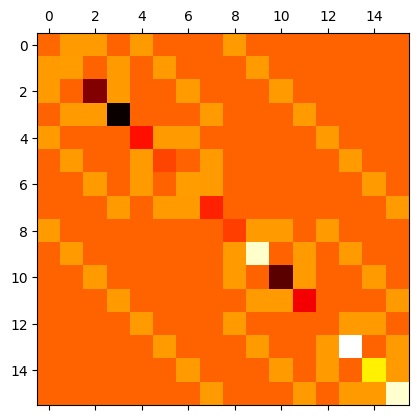

In [151]:
# Prints a visual representation of the Hamiltonian matrix
ham_matrix = create_hamiltonian_matrix(qubit_number, ising_graph, target_weights, target_bias)
plt.matshow(ham_matrix, cmap="hot")
plt.show()

In [152]:
low_energy_state = [
    (-0.054661080280306085 + 0.016713907320174026j),
    (0.12290003656489545 - 0.03758500591109822j),
    (0.3649337966440005 - 0.11158863596657455j),
    (-0.8205175732627094 + 0.25093231967092877j),
    (0.010369790825776609 - 0.0031706387262686003j),
    (-0.02331544978544721 + 0.007129899300113728j),
    (-0.06923183949694546 + 0.0211684344103713j),
    (0.15566094863283836 - 0.04760201916285508j),
    (0.014520590919500158 - 0.004441887836078486j),
    (-0.032648113364535575 + 0.009988590222879195j),
    (-0.09694382811137187 + 0.02965579457620536j),
    (0.21796861485652747 - 0.06668776658411019j),
    (-0.0027547112135013247 + 0.0008426289322652901j),
    (0.006193695872468649 - 0.0018948418969390599j),
    (0.018391279795405405 - 0.005625722994009138j),
    (-0.041350974715649635 + 0.012650711602265649j),
]

In [153]:
res = np.vdot(low_energy_state, (ham_matrix @ low_energy_state))
energy_exp = np.real_if_close(res)
print(f"Energy Expectation: {energy_exp}")


ground_state_energy = np.real_if_close(min(np.linalg.eig(ham_matrix)[0]))
print(f"Ground State Energy: {ground_state_energy}")

Energy Expectation: -7.244508985189116
Ground State Energy: -7.33068966129124


In [154]:
def state_evolve(hamiltonian, qubits, time):

    U = scipy.linalg.expm(-1j * hamiltonian * time)
    qml.QubitUnitary(U, wires=qubits)

In [155]:
def qgrnn_layer(weights, bias, qubits, graph, trotter_step):

    # Applies a layer of RZZ gates (based on a graph)
    for i, edge in enumerate(graph.edges):
        qml.MultiRZ(2 * weights[i] * trotter_step, wires=(edge[0], edge[1]))

    # Applies a layer of RZ gates
    for i, qubit in enumerate(qubits):
        qml.RZ(2 * bias[i] * trotter_step, wires=qubit)

    # Applies a layer of RX gates
    for qubit in qubits:
        qml.RX(2 * trotter_step, wires=qubit)

In [156]:
def swap_test(control, register1, register2):

    qml.Hadamard(wires=control)
    for reg1_qubit, reg2_qubit in zip(register1, register2):
        qml.CSWAP(wires=(control, reg1_qubit, reg2_qubit))
    qml.Hadamard(wires=control)

Edges: [(4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (6, 7)]


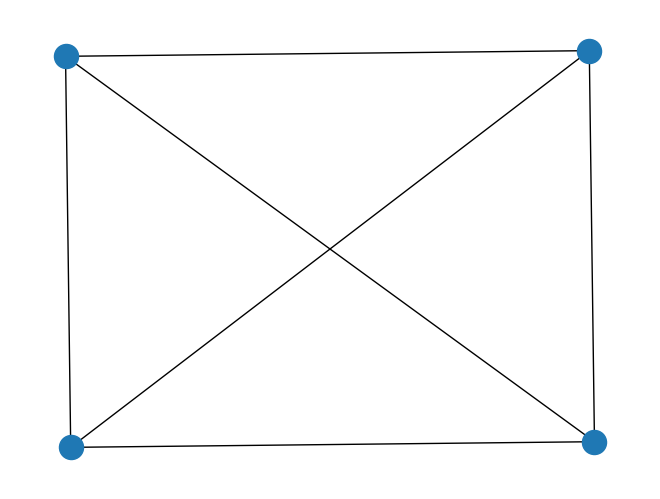

In [157]:
# Defines some fixed values

reg1 = tuple(range(qubit_number))  # First qubit register
reg2 = tuple(range(qubit_number, 2 * qubit_number))  # Second qubit register

control = 2 * qubit_number  # Index of control qubit
trotter_step = 0.01  # Trotter step size

# Defines the interaction graph for the new qubit system

new_ising_graph = nx.complete_graph(reg2)

print(f"Edges: {new_ising_graph.edges}")
nx.draw(new_ising_graph)

In [158]:
def qgrnn(weights, bias, time=None):

    # Prepares the low energy state in the two registers
    qml.StatePrep(np.kron(low_energy_state, low_energy_state), wires=reg1 + reg2)

    # Evolves the first qubit register with the time-evolution circuit to
    # prepare a piece of quantum data
    state_evolve(ham_matrix, reg1, time)

    # Applies the QGRNN layers to the second qubit register
    depth = time / trotter_step  # P = t/Delta
    for _ in range(0, int(depth)):
        qgrnn_layer(weights, bias, reg2, new_ising_graph, trotter_step)

    # Applies the SWAP test between the registers
    swap_test(control, reg1, reg2)
    # Returns the results of the SWAP test
    return qml.expval(qml.PauliZ(control))

In [159]:
N = 15  # The number of pieces of quantum data that are used for each step
max_time = 0.1  # The maximum value of time that can be used for quantum data

In [160]:
rng = np.random.default_rng(seed=42)

def cost_function(weight_params, bias_params):

    # Randomly samples times at which the QGRNN runs
    times_sampled = rng.random(size=N) * max_time

    # Cycles through each of the sampled times and calculates the cost
    total_cost = 0
    for dt in times_sampled:
        result = qgrnn_qnode(weight_params, bias_params, time=dt)
        total_cost += -1 * result

    return total_cost / N

In [161]:
rng = np.random.default_rng(seed=42)

def cost_function(weight_params, bias_params):

    # Randomly samples times at which the QGRNN runs
    times_sampled = rng.random(size=N) * max_time

    # Cycles through each of the sampled times and calculates the cost
    total_cost = 0
    for dt in times_sampled:
        result = qgrnn_qnode(weight_params, bias_params, time=dt)
        total_cost += -1 * result

    return total_cost / N

In [162]:
# Defines the new device
qgrnn_dev = qml.device("default.qubit", wires=2 * qubit_number + 1)

# Defines the new QNode
qgrnn_qnode = qml.QNode(qgrnn, qgrnn_dev)

steps = 300

optimizer = qml.AdamOptimizer(stepsize=0.5)

weights = rng.random(size=len(new_ising_graph.edges), requires_grad=True) - 0.5
bias = rng.random(size=qubit_number, requires_grad=True) - 0.5

initial_weights = copy.copy(weights)
initial_bias = copy.copy(bias)

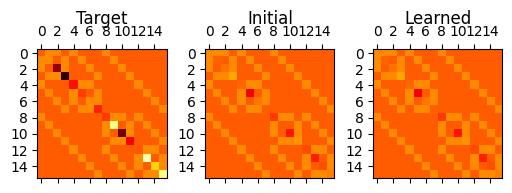

In [163]:
new_ham_matrix = create_hamiltonian_matrix(
    qubit_number, nx.complete_graph(qubit_number), weights, bias
)

init_ham = create_hamiltonian_matrix(
    qubit_number, nx.complete_graph(qubit_number), initial_weights, initial_bias
)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 6))

axes[0].matshow(ham_matrix, vmin=-7, vmax=7, cmap="hot")
axes[0].set_title("Target", y=1.13)

axes[1].matshow(init_ham, vmin=-7, vmax=7, cmap="hot")
axes[1].set_title("Initial", y=1.13)

axes[2].matshow(new_ham_matrix, vmin=-7, vmax=7, cmap="hot")
axes[2].set_title("Learned", y=1.13)

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()